# Baseline Experiment Plots

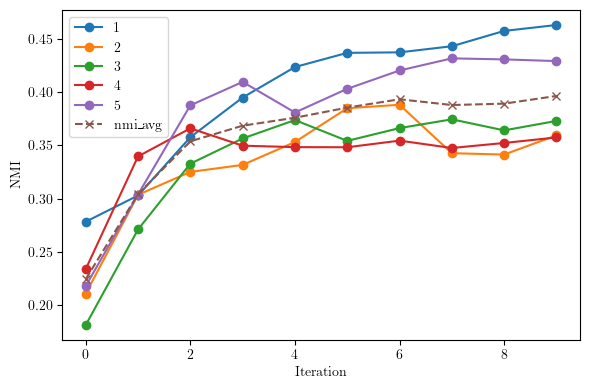

                   1         2         3         4         5       avg
ari_true    0.310085  0.245329  0.220307  0.212467  0.294123  0.256462
dbi         1.303248  1.605189  1.326504  1.271298  1.255203       NaN
nmi_prev    0.859986  0.723132  0.808258  0.774721  0.805801       NaN
nmi_true    0.463190  0.359497  0.373073  0.357566  0.429296  0.396524
silhouette  0.249975  0.192050  0.251892  0.222476  0.256208  0.234520


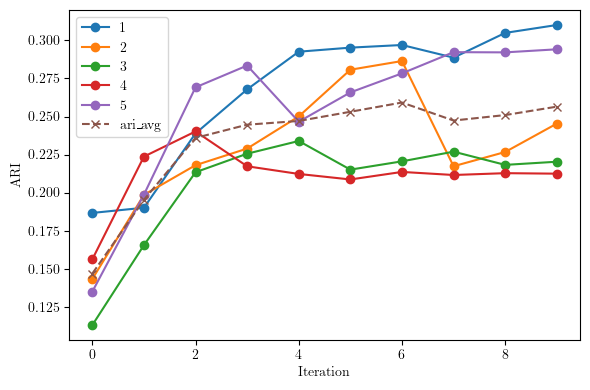

                   1         2         3         4         5       avg
ari_true    0.310085  0.245329  0.220307  0.212467  0.294123  0.256462
dbi         1.303248  1.605189  1.326504  1.271298  1.255203       NaN
nmi_prev    0.859986  0.723132  0.808258  0.774721  0.805801       NaN
nmi_true    0.463190  0.359497  0.373073  0.357566  0.429296  0.396524
silhouette  0.249975  0.192050  0.251892  0.222476  0.256208  0.234520


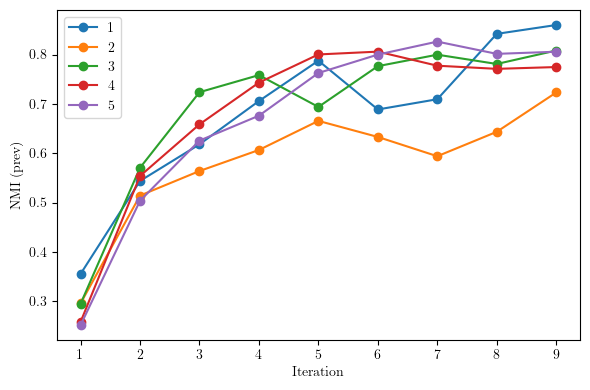

                   1         2         3         4         5       avg
ari_true    0.310085  0.245329  0.220307  0.212467  0.294123  0.256462
dbi         1.303248  1.605189  1.326504  1.271298  1.255203       NaN
nmi_prev    0.859986  0.723132  0.808258  0.774721  0.805801       NaN
nmi_true    0.463190  0.359497  0.373073  0.357566  0.429296  0.396524
silhouette  0.249975  0.192050  0.251892  0.222476  0.256208  0.234520


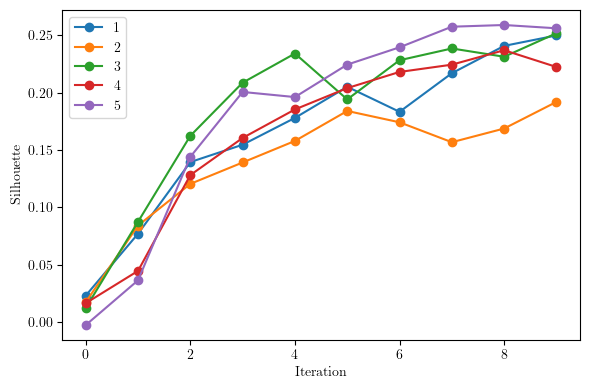

                   1         2         3         4         5       avg
ari_true    0.310085  0.245329  0.220307  0.212467  0.294123  0.256462
dbi         1.303248  1.605189  1.326504  1.271298  1.255203       NaN
nmi_prev    0.859986  0.723132  0.808258  0.774721  0.805801       NaN
nmi_true    0.463190  0.359497  0.373073  0.357566  0.429296  0.396524
silhouette  0.249975  0.192050  0.251892  0.222476  0.256208  0.234520


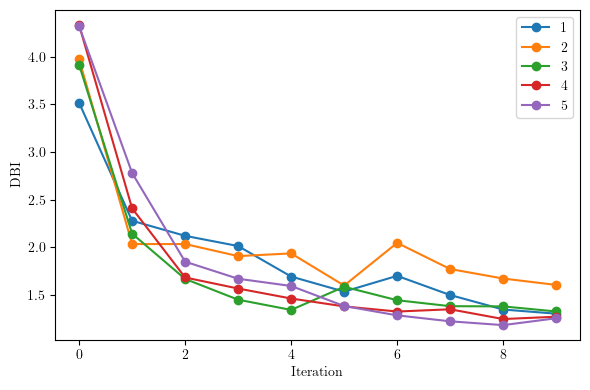

                   1         2         3         4         5       avg
ari_true    0.310085  0.245329  0.220307  0.212467  0.294123  0.256462
dbi         1.303248  1.605189  1.326504  1.271298  1.255203       NaN
nmi_prev    0.859986  0.723132  0.808258  0.774721  0.805801       NaN
nmi_true    0.463190  0.359497  0.373073  0.357566  0.429296  0.396524
silhouette  0.249975  0.192050  0.251892  0.222476  0.256208  0.234520


In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Enable LaTeX font (optional)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

def load_metrics(run_paths):
    all_data = {}
    for run_name, run_path in run_paths.items():
        metrics_file = os.path.join(run_path, 'metrics.json')
        if os.path.isfile(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
            all_data[run_name] = metrics
    return all_data

run_path = './experiments/run_baseline_20250115_175127' # baseline

labels_baseline = ['1',
                    '2',
                    '3',
                    '4',
                    '5',
]

run_paths = {}
for i, label in enumerate(labels_baseline):
    run_paths[label] = run_path + f'/config_{i+1}'

metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'ari_true', 'nmi_prev', 'silhouette', 'dbi']
metrics_legend = {
    'nmi_true': 'NMI',
    'ari_true': 'ARI',
    'nmi_prev': 'NMI (prev)',
    'silhouette': 'Silhouette',
    'dbi': 'DBI',
}

# save average of nmi_true series to nmi_avg
nmi_avg = []
ari_avg = []
silhouette_avg = []
for run_name, df in dfs.items():
    nmi_avg.append(df['nmi_true'])
    ari_avg.append(df['ari_true'])
    silhouette_avg.append(df['silhouette'])
nmi_avg = pd.concat(nmi_avg, axis=1).mean(axis=1)
ari_avg = pd.concat(ari_avg, axis=1).mean(axis=1)
silhouette_avg = pd.concat(silhouette_avg, axis=1).mean(axis=1)
dfs['avg'] = pd.DataFrame({'nmi_true': nmi_avg, 'ari_true': ari_avg, 'silhouette': silhouette_avg})

nmi_avg = nmi_avg.to_numpy()
ari_avg = ari_avg.to_numpy()
silhouette_avg = silhouette_avg.to_numpy()


# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    
    # Plot this metric for each config/run
    for i, run_name in enumerate(labels_baseline):
        plt.plot(dfs[run_name][metric], label=run_name, marker='o')
    
    # Plot nmi_avg and ari_avg if the metric is 'nmi_true' or 'ari_true'
    if metric == 'nmi_true':
        plt.plot(nmi_avg, label='nmi_avg', marker='x', linestyle='--')
    elif metric == 'ari_true':
        plt.plot(ari_avg, label='ari_avg', marker='x', linestyle='--')
    
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()

    # Save the plot in experiments folder
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


    # create table with last iteration values of each metric
    last_iteration = {}
    for run_name, df in dfs.items():
        last_iteration[run_name] = df.iloc[-1]
    last_iteration_df = pd.DataFrame(last_iteration)
    print(last_iteration_df)



# Noise Experiment Evaluation Plots

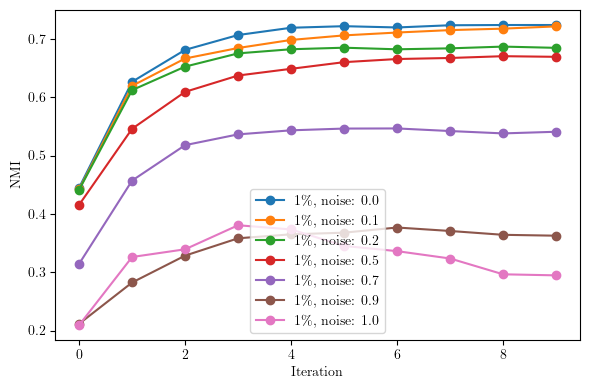

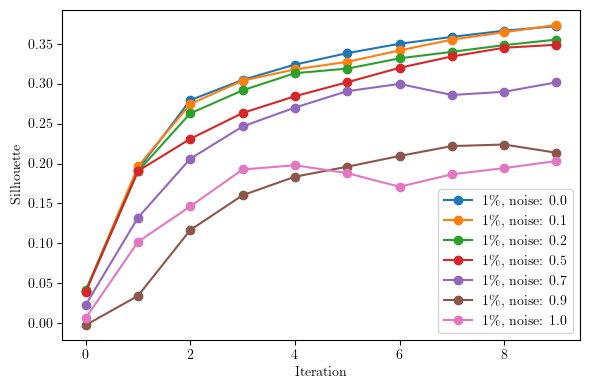

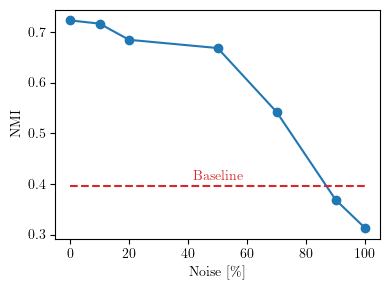

            1\%, noise: 0.0  1\%, noise: 0.01  1\%, noise: 0.05  \
nmi_true           0.724116          0.704990          0.750429   
ari_true           0.686937          0.650053          0.718188   
nmi_prev           0.929705          0.934002          0.933509   
silhouette         0.371978          0.357824          0.393663   
dbi                1.021246          1.074443          0.968823   

            1\%, noise: 0.1  1\%, noise: 0.2  1\%, noise: 0.5  \
nmi_true           0.721742         0.684936         0.669534   
ari_true           0.667856         0.621419         0.592157   
nmi_prev           0.926619         0.936571         0.918502   
silhouette         0.373404         0.355153         0.348669   
dbi                1.022371         1.051875         1.056332   

            1\%, noise: 0.7  1\%, noise: 0.9  1\%, noise: 1.0  
nmi_true           0.541005         0.362715         0.294674  
ari_true           0.384051         0.245349         0.168538  
nmi_prev      

In [3]:
run_path = './experiments/run_noise_20250115_160055' # noise

labels_noise = ['1\%, noise: 0.0', 
                '1\%, noise: 0.01',
                '1\%, noise: 0.05',
                '1\%, noise: 0.1',
                '1\%, noise: 0.2',
                '1\%, noise: 0.5',
                '1\%, noise: 0.7',
                '1\%, noise: 0.9',
                '1\%, noise: 1.0',
               ]  

# run_paths = {}
# for i, label in enumerate(labels_noise):
#     run_paths[label] = run_path + f'/config_{i+1}'
#     metrics_dict = load_metrics(run_paths)

run_paths_1 = {}
for i in range(len(labels_noise)):
    run_paths_1[labels_noise[i]] = run_path + f'/config_{i+1}'
    metrics_dict_1 = load_metrics(run_paths_1)

# Collect metrics into DataFrames
dfs_1 = {}
for run_name, m in metrics_dict_1.items():
    dfs_1[run_name] = pd.DataFrame(m)


# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']
metrics_legend = {
    'nmi_true': 'NMI',
    'silhouette': 'Silhouette',
}

# %matplotlib qt
%matplotlib inline

use_indecis = [0, 3, 4, 5, 6, 7, 8]

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    for i in use_indecis:
        run_name = labels_noise[i]
        df = dfs_1[run_name]
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=run_name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


# extract nmi scores of last epoch for each config
nmi_last = []
for run_name, df in dfs_1.items():
    nmi_last.append(df['nmi_true'].iloc[-4:].mean())

# create label_noise list which is only the percentage
labels_noise_percentage = [0, 1,5,10, 20, 50, 70, 90, 100]



# Remove elements at index 1 and 2 from nmi_last and labels_noise_percentage
nmi_last_filtered = [nmi_last[i] for i in range(len(nmi_last)) if i not in [1, 2]]
labels_noise_percentage_filtered = [labels_noise_percentage[i] for i in range(len(labels_noise_percentage)) if i not in [1, 2]]

# Plot nmi_last vs noise
plt.figure(figsize=(4, 3))
plt.plot(labels_noise_percentage_filtered, nmi_last_filtered, marker='o')
plt.hlines(y=nmi_avg[-1], xmin=0, xmax=100, color=(215/255, 40/255, 40/255), linestyle='--', label='avg')
plt.text(50, nmi_avg[-1] + 0.01, 'Baseline', color=(215/255, 40/255, 40/255), ha='center')
plt.ylabel('NMI')
plt.xlabel('Noise [\%]')
plt.tight_layout()
plt.savefig(f'{run_path}/nmi_last_vs_noise.pdf')
plt.show()

# create table with last iteration values of each metric
last_iteration = {}
for run_name, df in dfs_1.items():
    last_iteration[run_name] = df.iloc[-1]
last_iteration_df = pd.DataFrame(last_iteration)
print(last_iteration_df)


# Overall Sparsity Experiment Plots

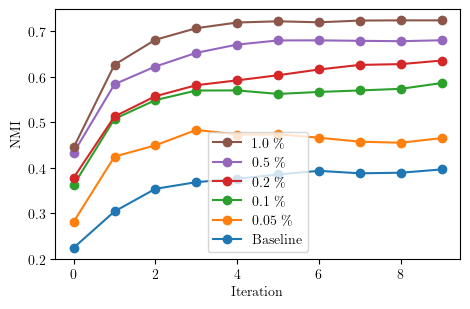

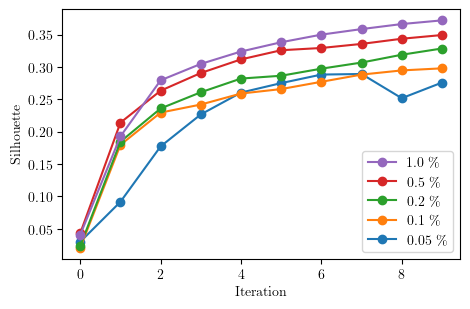

Final NMI: 0.396524494271258
Final ARI: 0.2564622408123965
Final Silhouette: 0.23452017307281495
             0.05 \%    0.1 \%    0.2 \%    0.5 \%    1.0 \%
nmi_true    0.465339  0.586339  0.635767  0.680363  0.724116
ari_true    0.287308  0.480663  0.529445  0.613717  0.686937
nmi_prev    0.807774  0.856445  0.894893  0.898610  0.929705
silhouette  0.275823  0.297864  0.328511  0.349318  0.371978
dbi         1.245785  1.152178  1.083618  1.140131  1.021246


In [4]:
run_path = './experiments/run_sparsity_20250115_150532' # overall sparsity

labels_overall_sparsity = ['0.0 \%',
            '0.05 \%',
            '0.1 \%',
            '0.2 \%',
            '0.5 \%',
            '1.0 \%'
]

indices_overall_sparsity = [2, 3, 4, 5, 6]

run_paths = {}
for i in indices_overall_sparsity:
    run_paths[labels_overall_sparsity[i-1]] = run_path + f'/config_{i}'
    metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)



# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6*0.8, 4*0.8))
    # Plot nmi_avg if the metric is 'nmi_true'
    if metric == 'nmi_true':
        plt.plot(nmi_avg, label='Baseline', marker='o')

    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_overall_sparsity[indices_overall_sparsity[i]-1], marker='o')
        i+=1
    
    
    
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    # Get handles and labels from the plot
    handles, labels = plt.gca().get_legend_handles_labels()

    # Reverse the order of handles and labels
    plt.legend(handles[::-1], labels[::-1])

    plt.tight_layout()
    plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()

print(f"Final NMI: {nmi_avg[-1]}")
print(f"Final ARI: {ari_avg[-1]}")
print(f"Final Silhouette: {silhouette_avg[-1]}")
# create table with last iteration values of each metric
last_iteration = {}
for run_name, df in dfs.items():
    last_iteration[run_name] = df.iloc[-1]
last_iteration_df = pd.DataFrame(last_iteration)
print(last_iteration_df)

# Classwise Experiment Evaluation Plot

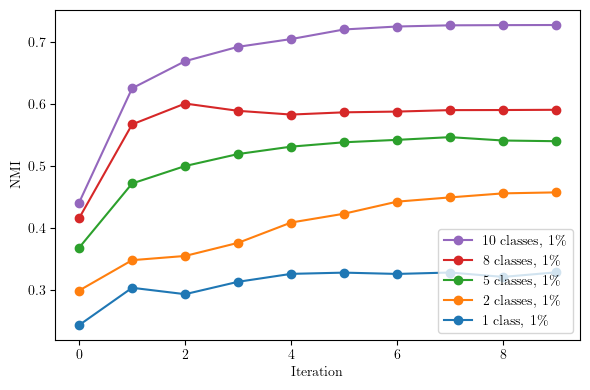

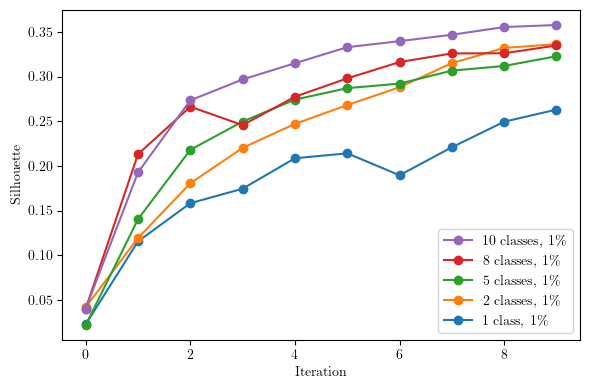

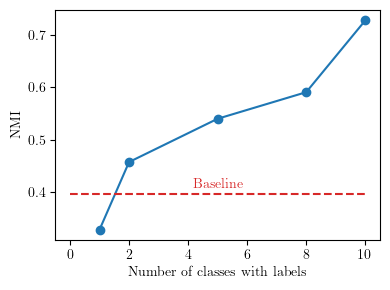

In [5]:
run_path = './experiments/run_classwise_20250115_145625' # classwise

labels_classwise = ['1 class, 0.1 \%',
                    '1 class, 1\%',
                    '2 classes, 0.1\%',
                    '2 classes, 1\%',
                    '5 classes, 0.1\%',
                    '5 classes, 1\%',
                    '8 classes, 0.1\%',
                    '8 classes, 1\%',
                    '10 classes, 1\%',
]

indices_classwise = [2, 4, 6, 8, 9]

run_paths = {}

for i in indices_classwise:
    run_paths[labels_classwise[i-1]] = run_path + f'/config_{i}'
    metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_classwise[indices_classwise[i]-1], marker='o')
        i+=1
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    # Get handles and labels from the plot
    handles, labels = plt.gca().get_legend_handles_labels()

    # Reverse the order of handles and labels
    plt.legend(handles[::-1], labels[::-1])

    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


# extract nmi scores of last epoch for each config
nmi_last = []
for run_name, df in dfs.items():
    nmi_last.append(df['nmi_true'].iloc[-1])

# create label_noise list which is only the percentage
labels_classes = [1, 2, 5, 8, 10]

#plot nmi_last vs noise
plt.figure(figsize=(4, 3))
plt.plot(labels_classes, nmi_last, marker='o')
plt.hlines(y=nmi_avg[-1], xmin=0, xmax=10, color=(215/255, 40/255, 40/255), linestyle='--', label='avg')
plt.text(5, nmi_avg[-1] + 0.01, 'Baseline', color=(215/255, 40/255, 40/255), ha='center')
plt.ylabel('NMI')
plt.xlabel('Number of classes with labels')
plt.tight_layout()
plt.savefig(f'{run_path}/nmi_last_vs_classes.pdf')
plt.show()


# Granularity Experiment Plots

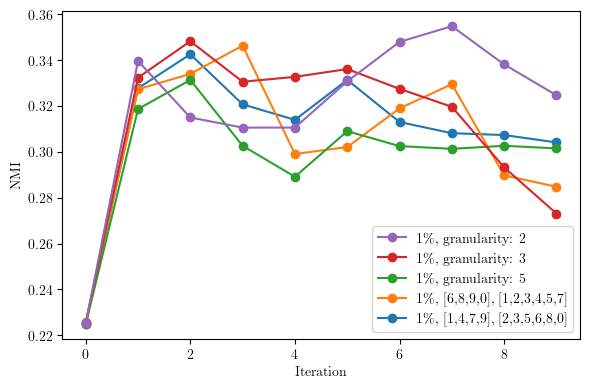

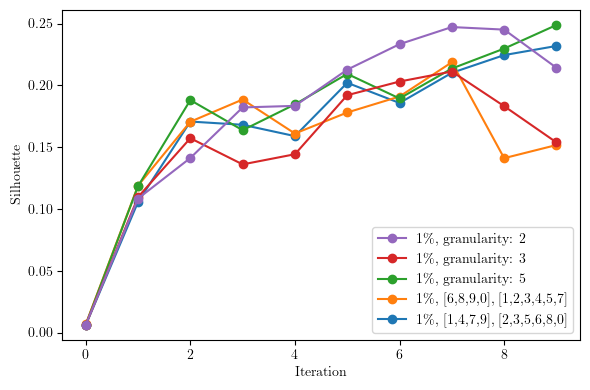

In [6]:
run_path = './experiments/run_granularity_20250115_170801' # granularity

# experiments_granularity = [
#     {**default_args, 'label_fraction': 0.01, 'must_link_fraction': 0.0, 'custom_clusters': [[1,4,7,9], [2,3,5,6,8,0]]},
#     {**default_args, 'label_fraction': 0.01, 'must_link_fraction': 0.0, 'custom_clusters': [[6,8,9,0], [1,2,3,4,5,7]]},
#     {**default_args, 'label_fraction': 0.01, 'must_link_fraction': 0.0, 'granularity': 5},
#     {**default_args, 'label_fraction': 0.01, 'must_link_fraction': 0.0, 'granularity': 3},
#     {**default_args, 'label_fraction': 0.01, 'must_link_fraction': 0.0, 'granularity': 2},
# ]

labels_granularity = ['1\%, [1,4,7,9], [2,3,5,6,8,0]',
                        '1\%, [6,8,9,0], [1,2,3,4,5,7]',
                        '1\%, granularity: 5',
                        '1\%, granularity: 3',
                        '1\%, granularity: 2'
]

indices_granularity = [1, 2, 3, 4, 5]

run_paths = {}

for i in indices_granularity:
    run_paths[labels_granularity[i-1]] = run_path + f'/config_{i}'

metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_granularity[indices_granularity[i]-1], marker='o')
        i+=1
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    # Get handles and labels from the plot
    handles, labels = plt.gca().get_legend_handles_labels()

    # Reverse the order of handles and labels
    plt.legend(handles[::-1], labels[::-1])

    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


# Dynamic Availibility Experiments Plots

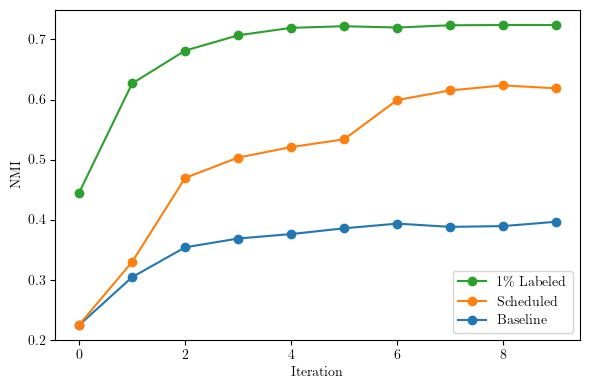

In [7]:
run_path_scheduled = './experiments/run_dynamic_20250115_192501' # must link


# use 1% labeled from overall sparsity for 1\%
run_path_sprasity = './experiments/run_sparsity_20250115_150532' # overall sparsity

labels_dynamic = ['Baseline',
                  'Schedule 1',
                  '1p'
]

run_paths_scheduled = {}
run_paths_scheduled['Schedule 1'] = run_path_scheduled + f'/config_1'
metrics_dict_scheduled = load_metrics(run_paths_scheduled)

run_paths_1p = {}
run_paths_1p['1p'] = run_path_sprasity + f'/config_6'
metrics_dict_1p = load_metrics(run_paths_1p)

# plot all three together
dfs_dynamic = {}
for run_name, m in metrics_dict_scheduled.items():
    dfs_dynamic['Schedule1'] = pd.DataFrame(m)
for run_name, m in metrics_dict_1p.items():
    dfs_dynamic['1p'] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true']

# %matplotlib qt
%matplotlib inline

plt.figure(figsize=(6, 4))

# Plot baseline nmi_avg
plt.plot(nmi_avg, label='Baseline', marker='o')

# Plot Schedule 1
plt.plot(dfs_dynamic['Schedule1']['nmi_true'], label='Scheduled', marker='o')

# Plot 1%
plt.plot(dfs_dynamic['1p']['nmi_true'], label='1\% Labeled', marker='o')

plt.xlabel('Iteration')
plt.ylabel('NMI')
handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the order of handles and labels
plt.legend(handles[::-1], labels[::-1])
plt.tight_layout()
plt.savefig(f'{run_path_scheduled}/nmi_comparison.pdf')
plt.show()
                  